In [1]:
import pandas as pd
import ast
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# 英語のstopwordsセットを用意
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taka2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('../data/merged_output.csv')

C:\Users\taka2\AppData\Local\Temp\ipykernel_25768\2164475089.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/merged_output.csv')


In [4]:
df.head()

,Unnamed: 0,url,type,original_url,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,...,root_domain,original_url.1,final_url,redirect_chain,redirect_count,head_elements,timeout,has_meta_refresh,meta_refresh_url,duration_sec
0,0,br-icloud.com.br,phishing,br-icloud.com.br,2,16,br-icloud.com.br,13,0,3,...,br-icloud,http://br-icloud.com.br,http://br-icloud.com.br/,NaN,0,NaN,False,False,NaN,4.55
1,1,mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com/music/krizz_kaliko.html,0,35,mp3raid.com,29,1,5,...,mp3raid,http://mp3raid.com/music/krizz_kaliko.html,http://mp3raid.com/music/krizz_kaliko.html,NaN,0,NaN,False,False,NaN,2.78
2,2,bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org/rexroth/cr/1.htm,0,31,bopsecrets.org,25,1,5,...,bopsecrets,http://bopsecrets.org/rexroth/cr/1.htm,https://bopsecrets.org/rexroth/cr/1.htm,"[{""url"": ""http://bopsecrets.org/rexroth/cr/1.h...",1,"[{'tag': 'meta', 'attributes': {'http-equiv': ...",False,False,NaN,6.41
3,3,http://garage-pirenne.be/index.php?option=com_...,defacement,http://www.garage-pirenne.be/index.php?option=...,1,77,garage-pirenne.be,60,7,17,...,garage-pirenne,http://www.garage-pirenne.be/index.php?option=...,http://www.garage-pirenne.be/index.php?option=...,NaN,0,NaN,False,False,NaN,4.71
4,4,http://adventure-nicaragua.net/index.php?optio...,defacement,http://adventure-nicaragua.net/index.php?optio...,1,228,adventure-nicaragua.net,199,22,14,...,adventure-nicaragua,http://adventure-nicaragua.net/index.php?optio...,http://adventure-nicaragua.net/index.php?optio...,NaN,0,NaN,False,True,http://adventure-nicaragua.net/index.php?optio...,4.51


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617125 entries, 0 to 617124
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           617125 non-null  int64  
 1   url                  617125 non-null  object 
 2   type                 617125 non-null  object 
 3   original_url         617125 non-null  object 
 4   url_type             617125 non-null  int64  
 5   url_len              617125 non-null  int64  
 6   pri_domain           617125 non-null  object 
 7   letters_count        617125 non-null  int64  
 8   digits_count         617125 non-null  int64  
 9   special_chars_count  617125 non-null  int64  
 10  shortened            617125 non-null  int64  
 11  is_domain_in_url     617125 non-null  int64  
 12  secure_http          617125 non-null  int64  
 13  have_ip              617125 non-null  object 
 14  url_region           617125 non-null  object 
 15  root_domain      

In [6]:
# ✅ 1. head_elements列からmetaとtitleを抽出
def extract_meta_and_title_tags(head_elements_str):
    try:
        elements = ast.literal_eval(head_elements_str)
        meta_tags = [el for el in elements if el.get("tag") == "meta"]
        title_text = next((el.get("text", "") for el in elements if el.get("tag") == "title"), "")
        return meta_tags, title_text
    except Exception:
        return [], ""

df[['meta_tags', 'title_text']] = df['head_elements'].apply(
    lambda x: pd.Series(extract_meta_and_title_tags(x))
)


In [8]:
# ✅ 2. metaタグからkeywords, descriptionのcontentを抽出
def extract_meta_content(meta_tags, target_name):
    for tag in meta_tags:
        if not isinstance(tag, dict):
            continue
        attrs = tag.get("attributes")
        if not isinstance(attrs, dict):
            continue
        if attrs.get("name", "").lower() == target_name:
            return attrs.get("content", "")
    return ""

df['keywords_content'] = df['meta_tags'].apply(lambda tags: extract_meta_content(tags, "keywords"))
df['description_content'] = df['meta_tags'].apply(lambda tags: extract_meta_content(tags, "description"))

In [39]:
# ✅ 3. スパム判定ロジック（同じ単語3回以上 or タイトル長すぎ）
def detect_spam(text, threshold=3, max_len=None):
    if not text:
        return False
    words = re.findall(r'\b\w+\b', text.lower())
    # stopword を除外
    filtered_words = [w for w in words if w not in stop_words]
    word_counts = Counter(filtered_words)
    
    if any(count >= threshold for count in word_counts.values()):
        return True
    if max_len is not None and len(text) > max_len:
        return True
    return False


In [40]:
# ✅ 4. スパムフラグ判定
df['keywords_spam'] = df['keywords_content'].apply(lambda x: detect_spam(x))
df['description_spam'] = df['description_content'].apply(lambda x: detect_spam(x))
df['title_spam'] = df['title_text'].apply(lambda x: detect_spam(x, max_len=70))

In [41]:
# ✅ 5. 総合フラグ
df['has_seo_spam'] = df['keywords_spam'] | df['description_spam'] | df['title_spam']

In [42]:
print(df[['url', 'has_seo_spam']].head(10))

                                                 url  has_seo_spam
0                                   br-icloud.com.br         False
1                mp3raid.com/music/krizz_kaliko.html         False
2                    bopsecrets.org/rexroth/cr/1.htm         False
3  http://garage-pirenne.be/index.php?option=com_...         False
4  http://adventure-nicaragua.net/index.php?optio...         False
5  http://buzzfil.net/m/show-art/ils-etaient-loin...         False
6      espn.go.com/nba/player/_/id/3457/brandon-rush         False
7     yourbittorrent.com/?q=anthony-hamilton-soulife         False
8           http://pashminaonline.com/pure-pashminas         False
9      allmusic.com/album/crazy-from-the-heat-r16990         False


In [31]:
print("스팸 판정된 URL 수:", df['has_seo_spam'].sum())
print("전체 URL 수:", len(df))
print("스팸 비율: {:.2f}%".format((df['has_seo_spam'].sum() / len(df)) * 100))

스팸 판정된 URL 수: 47630
전체 URL 수: 617125
스팸 비율: 7.72%


In [32]:
print(df['has_seo_spam'].value_counts())

has_seo_spam
False    569495
True      47630
Name: count, dtype: int64


In [15]:
df.to_csv('../data/has_seo_spam.csv', index=False)

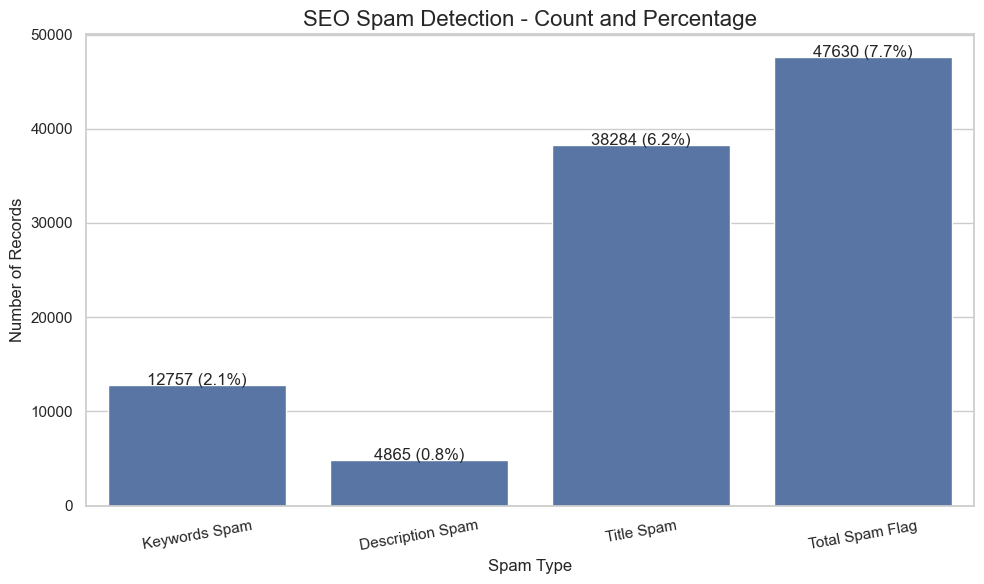

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Use a common English font to avoid glyph issues
matplotlib.rcParams['font.family'] = 'Arial'

# Style setup for readability
sns.set(style="whitegrid")

# Count True values in each spam detection column
spam_counts = {
    'Keywords Spam': df['keywords_spam'].sum(),
    'Description Spam': df['description_spam'].sum(),
    'Title Spam': df['title_spam'].sum(),
    'Total Spam Flag': df['has_seo_spam'].sum()
}

# Convert to DataFrame for plotting
spam_df = pd.DataFrame(list(spam_counts.items()), columns=["Spam Type", "Count"])

# 割合追加
total = len(df)
spam_df['Ratio (%)'] = spam_df['Count'] / total * 100

# 棒グラフ描画（値付き）
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x="Spam Type", y="Count", data=spam_df)

# 上に数値と割合表示
for index, row in spam_df.iterrows():
    barplot.text(index, row['Count'] + 1, f"{row['Count']} ({row['Ratio (%)']:.1f}%)", ha='center')

plt.title("SEO Spam Detection - Count and Percentage", fontsize=16)
plt.xlabel("Spam Type", fontsize=12)
plt.ylabel("Number of Records", fontsize=12)
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()


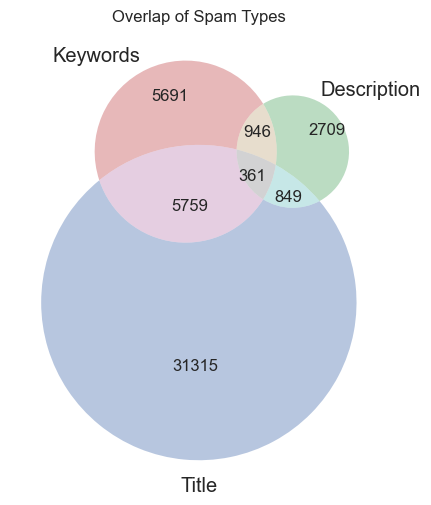

In [34]:
from matplotlib_venn import venn3

# 各条件に該当する集合を構成
set_keywords = set(df[df['keywords_spam']].index)
set_description = set(df[df['description_spam']].index)
set_title = set(df[df['title_spam']].index)

plt.figure(figsize=(8, 6))
venn3([set_keywords, set_description, set_title], set_labels=('Keywords', 'Description', 'Title'))
plt.title("Overlap of Spam Types")
plt.show()


In [35]:
total = len(df)
spam_df['Ratio (%)'] = spam_df['Count'] / total * 100
print(spam_df)


          Spam Type  Count  Ratio (%)
0     Keywords Spam  12757   2.067166
1  Description Spam   4865   0.788333
2        Title Spam  38284   6.203605
3   Total Spam Flag  47630   7.718047


In [36]:
# SEOスパムと判定された行を抽出
spam_df = df[df["has_seo_spam"] == True]

# typeカラムの頻度をカウント
type_counts = spam_df["type"].value_counts(dropna=False)

# 結果を表示
print("=== SEOスパムに分類されたデータのtype分布 ===")
print(type_counts)

=== SEOスパムに分類されたデータのtype分布 ===
type
benign        40159
phishing       4456
defacement     2948
malware          67
Name: count, dtype: int64


In [37]:
# 各スパムフラグごとにtype分布を表示
spam_columns = ["keywords_spam", "description_spam", "title_spam", "has_seo_spam"]

for col in spam_columns:
    print(f"\n=== {col} が True のときの type 分布 ===")
    print(df[df[col] == True]["type"].value_counts(dropna=False))


=== keywords_spam が True のときの type 分布 ===
type
benign        10280
phishing       1673
defacement      794
malware          10
Name: count, dtype: int64

=== description_spam が True のときの type 分布 ===
type
benign        3844
defacement     614
phishing       405
malware          2
Name: count, dtype: int64

=== title_spam が True のときの type 分布 ===
type
benign        32931
phishing       3217
defacement     2079
malware          57
Name: count, dtype: int64

=== has_seo_spam が True のときの type 分布 ===
type
benign        40159
phishing       4456
defacement     2948
malware          67
Name: count, dtype: int64


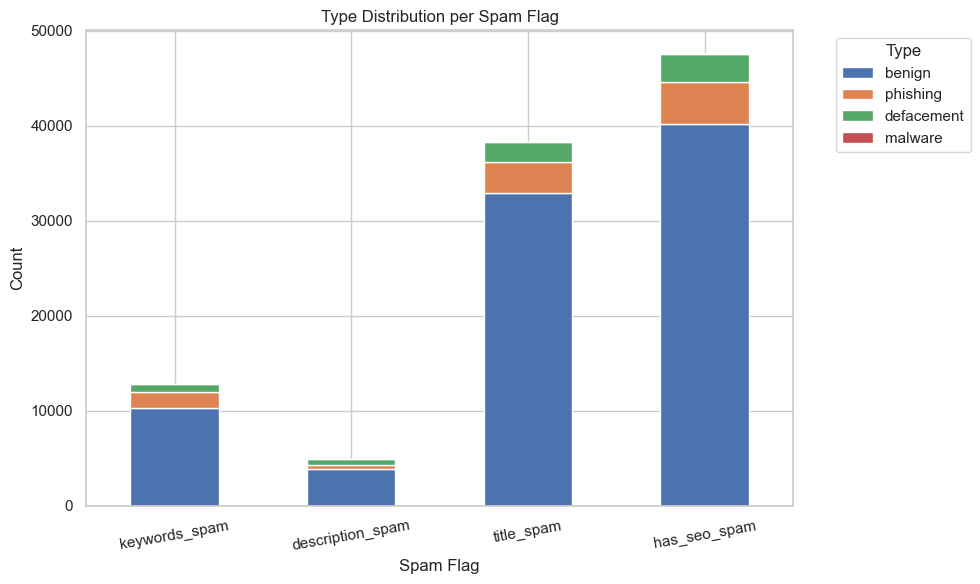

In [38]:
# 事前に読み込んだ df を使う想定
spam_columns = ["keywords_spam", "description_spam", "title_spam", "has_seo_spam"]
types = ["benign", "phishing", "defacement", "malware"]

# データ集計
data = {col: df[df[col] == True]["type"].value_counts().reindex(types, fill_value=0) for col in spam_columns}
plot_df = pd.DataFrame(data)

# 積み上げ棒グラフの描画
plot_df.T.plot(kind="bar", stacked=True, figsize=(10, 6))

plt.title("Type Distribution per Spam Flag")
plt.xlabel("Spam Flag")
plt.ylabel("Count")
plt.xticks(rotation=10)
plt.legend(title="Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [43]:
from collections import Counter

# ✅ n-gram繰り返しスコアを計算する関数
def ngram_repetition_score(text, n=2):
    if not isinstance(text, str):
        return 0
    words = text.split()
    ngrams = [" ".join(words[i:i+n]) for i in range(len(words) - n + 1)]
    counts = Counter(ngrams)
    total = sum(counts.values())
    if total == 0:
        return 0
    repeated = sum(count for count in counts.values() if count > 1)
    return repeated / total

# ✅ メタタグの"content"を抽出する関数（すでに使用されていた関数と同じ）
def extract_meta_content(meta_tags, target_name):
    for tag in meta_tags:
        if not isinstance(tag, dict):
            continue
        attrs = tag.get("attributes")
        if not isinstance(attrs, dict):
            continue
        if attrs.get("name", "").lower() == target_name:
            return attrs.get("content", "")
    return ""

# ✅ DataFrameの列にコンテンツを抽出
df['keywords_content'] = df['meta_tags'].apply(lambda tags: extract_meta_content(tags, "keywords"))
df['description_content'] = df['meta_tags'].apply(lambda tags: extract_meta_content(tags, "description"))

# ✅ n-gramスコアの算出
df['keywords_ngram_score'] = df['keywords_content'].apply(lambda x: ngram_repetition_score(x, n=2))
df['description_ngram_score'] = df['description_content'].apply(lambda x: ngram_repetition_score(x, n=2))

# ✅ スパム判定（例: 0.3以上でスパムとみなす）
THRESHOLD = 0.3
df['keywords_spam'] = df['keywords_ngram_score'] > THRESHOLD
df['description_spam'] = df['description_ngram_score'] > THRESHOLD


In [45]:
# ✅ keywords_spam の True / False の件数を集計
keywords_spam_counts = df['keywords_spam'].value_counts().rename_axis('is_spam').reset_index(name='keywords_spam_count')

# ✅ description_spam の True / False の件数を集計
description_spam_counts = df['description_spam'].value_counts().rename_axis('is_spam').reset_index(name='description_spam_count')

# ✅ 2つの結果を is_spam（True/False）でマージして表示
spam_summary = pd.merge(keywords_spam_counts, description_spam_counts, on='is_spam', how='outer').fillna(0)

# ✅ 表示
print(spam_summary)


   is_spam  keywords_spam_count  description_spam_count
0    False               613281                  615562
1     True                 3844                    1563
